In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.ticker as mticker
from sklearn.linear_model import LinearRegression
from keras.utils import np_utils
import numpy.linalg as linalg
import seaborn as sn
import pandas as pd

# K-means

In [2]:
from kmeans import Kmeans

In [3]:
#Load data: old_faithful dataset
old_faithful = pd.read_csv('faithful.csv', sep=',',header=None)
old_faithful = old_faithful.values
old_faithful_coord = old_faithful[:,1:3]
centered_old_faithful = old_faithful_coord - np.mean(old_faithful_coord,0)
standardized_old_faithful = centered_old_faithful / np.std(old_faithful_coord,0)

In [4]:
km_faithful = Kmeans(K = 2, eps = 1e-10, seed=123)
km_faithful.fit_kmeans(standardized_old_faithful)

col = ["blue"]*len(km_faithful.labels)
for i in np.where(km_faithful.labels==1)[0]:
    col[i]="green"

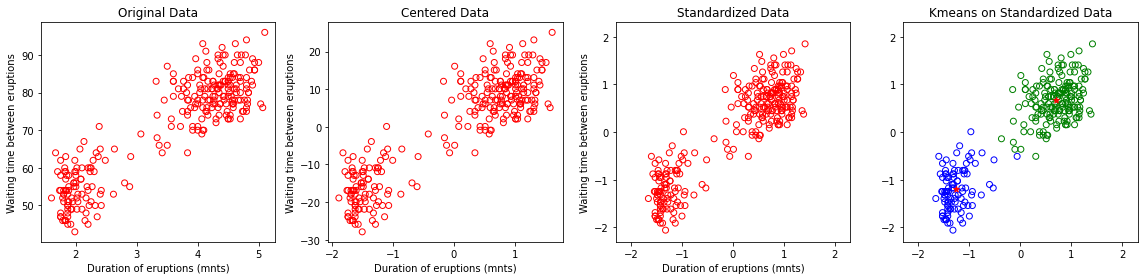

In [5]:
titles = ["Original Data", "Centered Data","Standardized Data","Kmeans on Standardized Data"]
data_list = [old_faithful_coord, centered_old_faithful,standardized_old_faithful]

fig = plt.figure(figsize=(16, 4))
for idx, data in enumerate(data_list):
    plt.tight_layout()
    ax = plt.subplot(1, 4, idx+1)
    ax.scatter(data[:,0], data[:,1], facecolors='none',edgecolors='r')
    ax.set_title(titles[idx])
    plt.xlabel("Duration of eruptions (mnts)")
    plt.ylabel("Waiting time between eruptions")
    if titles[idx] == "Standardized Data":
        ax.set_xlim([-2.3, 2.3])
        ax.set_ylim([-2.3, 2.3]) 

ax= plt.subplot(1, 4, 4)
ax.scatter(standardized_old_faithful[:,0],standardized_old_faithful[:,1], 
            facecolors='none',edgecolors = col)
ax.scatter(km_faithful.centroids[:,0], km_faithful.centroids[:,1], 
            marker = '*', c = "red")
ax.set_xlim([-2.3, 2.3])
ax.set_ylim([-2.3, 2.3]) 
ax.set_title("Kmeans on Standardized Data")
plt.show()

In [6]:
# As the waiting time between eruptions increases, the duration of the eruptions are longer 

# PCA

In [7]:
from pca import pca

In [8]:
#Experiments with old_faithful dataset
pca_old_faithful = pca(M=2)
pca_old_faithful.fit_pca(standardized_old_faithful.T)
slope_old_faithful = pca_old_faithful.eigenVectors[1]/pca_old_faithful.eigenVectors[0]

In [12]:
# Fit a linear regression to compare:
# y = mx + b => write y = Ap, st A = [[x , 1]] and p = [[m], [c]] => solve for p
A = np.vstack([standardized_old_faithful[:,0], np.ones(len(standardized_old_faithful[:,0]))]).T
slope_, intercept_ = linalg.lstsq(A, standardized_old_faithful[:,1], rcond=None)[0]

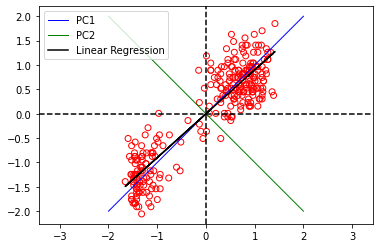

In [13]:
plt.scatter(standardized_old_faithful[:,0], standardized_old_faithful[:,1], 
            facecolors='none',edgecolors='r')
x = np.array([-2,2])
plt.plot(x,slope_old_faithful[0]*x, lw=1, c="blue",label="PC1")
plt.plot(x,slope_old_faithful[1]*x ,lw=1, c="green",label="PC2")
plt.axhline(y=0, xmin=0.0, xmax=1.0, linestyle='--', color='black')
plt.axvline(x=0, ymin=0.0, ymax=1.0, linestyle='--', color='black')
plt.plot(standardized_old_faithful[:,0],
         slope_* standardized_old_faithful[:,0] + intercept_,
         c="black", label = "Linear Regression")
plt.xlim(-2.3,2.3)
plt.ylim(-2.3,2.3)
plt.axis('equal')
plt.legend()
plt.show()

In [14]:
# Standardized data, together with the first principal component (blue line),  second principal
# component (green line) and linear regression line (black line).
# The principal components are new variables that are constructed as linear combinations
# of the initial variables.
# PC1 represents the first dimension, which is the best linear fit to the data. Is the line that 
# maximizes the variance and minimizes the orthogonal distance from the data point to the line. 
# PC2 represents the second dimension, which is the second best fit to the data,
# notice that PC2 it is perpendicular to PC1.
# Both, PC1 and the linear regression seem to be very close. However they still differ in some parts.
# The linear regression uses ordinary least squares to minimize the error,
# i.e minimizes the distance projected as a horizontal line from the data point to the line.

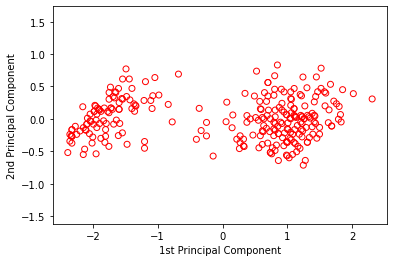

In [15]:
plt.scatter(pca_old_faithful.new_coordinates[0], pca_old_faithful.new_coordinates[1], 
            facecolors='none',edgecolors='r')
plt.xlabel('1st Principal Component')
plt.ylabel('2nd Principal Component')
plt.xlim(-2.8,2.8)
plt.ylim(-2.8,2.8)
plt.axis('equal')
plt.show()

In [20]:
new_coordinates_cov_m = pca_old_faithful.compute_cov_matrix(pca_old_faithful.new_coordinates)

In [22]:
#Notice that the data after the transformation is uncorrelated
# and the variance (diagonal elements) is given by the eigenvalues.
new_coordinates_cov_m

array([[1.90782523e+00, 3.14631470e-16],
       [3.14631470e-16, 9.95548421e-02]])

In [23]:
pca_old_faithful.eigenValues

array([1.90782523, 0.09955484])

In [24]:
from keras.datasets import mnist
((x_train, y_train),  (x_test, y_test)) = mnist.load_data()

In [25]:
#Experiments with only images of the digit 3
set_images3 = x_train[np.where(y_train==3)]
standard_set_images3 = pca.standardize_images_channel_wise(set_images3, 1e-10)
pca_set_3 = pca(M=28*28)
pca_set_3.fit_pca(standard_set_images3)

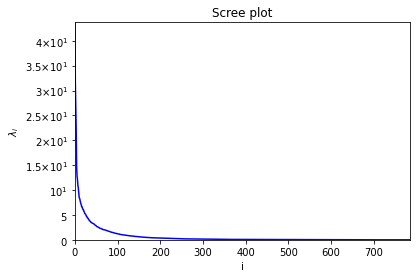

In [26]:
#Selecting a good value of M
pca_set_3.plot_eigenspectrum()

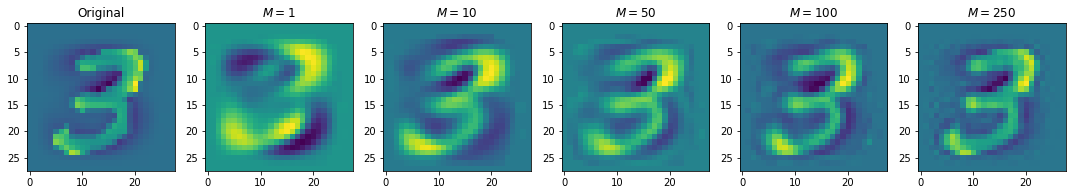

In [27]:
#Data Reconstruction 
M = [1,10,50,100, 250]
fig = plt.figure(figsize=(15, 4))
ax = plt.subplot(1, 6, 1)
ax.set_title("Original")
ax.imshow(standard_set_images3[:,0].reshape(28,28))
for idx, m in enumerate(M):
    plt.tight_layout()
    fig.subplots_adjust(top=0.88)
    ax = plt.subplot(1, 6, idx+2)
    ax.set_title(r"$M = {}$".format(m))
    ax.imshow(np.dot(pca_set_3.eigenVectors[:, 0:m],
                     pca_set_3.new_coordinates[0:m, :])[:,0].reshape(28,28))
plt.show()


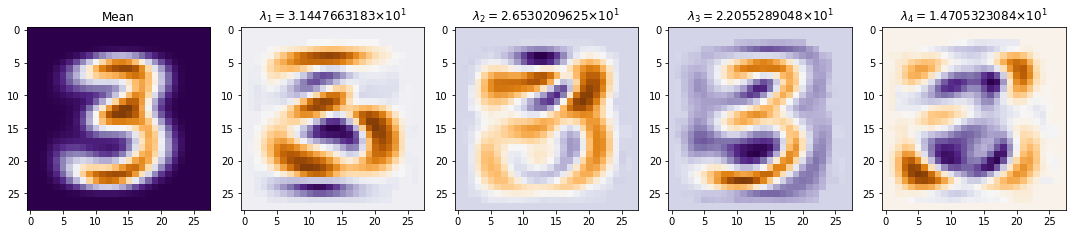

In [28]:
# First Four PCA eigenvectors
fig = plt.figure(figsize=(15, 4))
ax = plt.subplot(1, 5, 1)
ax.set_title("Mean")
ax.imshow(np.reshape(set_images3,(-1, 28 * 28)).mean(axis=0).reshape(28,28), cmap="PuOr_r")
for i in range(1,5):
    plt.tight_layout()
    fig.subplots_adjust(top=0.88)
    ax = plt.subplot(1, 5, i+1)
    f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
    #f.FormatStrFormatter('%.2f')
    ax.set_title(r"$\lambda_{} = {:}$".format(i, f._formatSciNotation('%1.10e' % pca_set_3.eigenValues[i]) ))
    ax.imshow(pca_set_3.eigenVectors[:,i].reshape(28,28), cmap="PuOr_r")
plt.show()


In [29]:
#Experiments with test data
standard_xtest = pca.standardize_images_channel_wise(x_test, 1e-10)
pca_mnist = pca(M=2)
pca_mnist.fit_pca(standard_xtest)

In [30]:
new_coordinates = np.vstack((pca_mnist.new_coordinates, y_test)).T
dataframe = pd.DataFrame(data=new_coordinates, columns=("1st_principal", "2nd_principal", "label"))


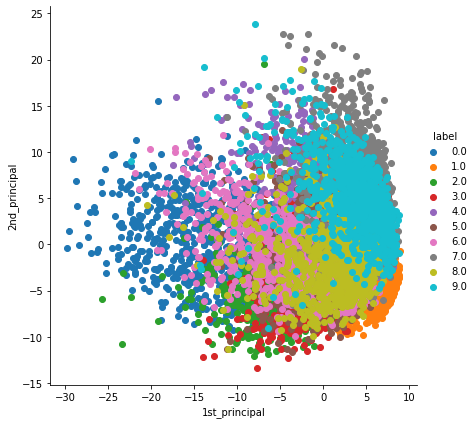

In [31]:
sn.FacetGrid(dataframe, hue="label", height=6).map(plt.scatter, '1st_principal', '2nd_principal').add_legend()
plt.show()